# NatuReX on CIFAR-10

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 20  # Increase if you want better accuracy
num_classes = 10
val_size = 5000

# Load and preprocess CIFAR-10
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# Define NatuReX activation
def naturEx(x, A=10.0, n=2.0):
    # f(x) = x / sqrt(1 + (x/A)^(2n))
    return x / tf.sqrt(1.0 + (x / A)**(2.0 * n))

initializer = tf.keras.initializers.HeNormal()

def build_model(activation_func, A=None, n=None, model_name="model"):
    # Simple CNN for CIFAR-10
    def act_layer(x):
        if activation_func == 'relu':
            return tf.nn.relu(x)
        else:
            return naturEx(x, A=A, n=n)

    inputs = tf.keras.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs, name=model_name)
    return model

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Accuracy: {logs.get('val_accuracy',0):.4f}")

def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

print("Training ReLU baseline model...")
model_relu = build_model('relu', model_name="relu_model")
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

model_relu.fit(x_train, y_train,
               validation_data=(x_val, y_val),
               epochs=epochs,
               batch_size=batch_size,
               verbose=1,
               callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)
print(f"ReLU Model:\nTest Accuracy: {test_acc_relu:.4f}\nSparsity: {relu_sparsity:.4f}\n"
      f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

A_values = [2.0, 10.0]
n_values = [2.0, 3.0]
optimizer_classes = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]

naturex_models = {}

for opt_class in optimizer_classes:
    opt_name = opt_class.__name__
    for A_val in A_values:
        for n_val in n_values:
            print(f"\nTraining NatuReX model with A={A_val}, n={n_val}, optimizer={opt_name}...")
            model_name = f"naturex_A{A_val}_n{n_val}_{opt_name}"
            model_naturex = build_model('naturex', A=A_val, n=n_val, model_name=model_name)
            optimizer_instance = opt_class(learning_rate=learning_rate)
            model_naturex.compile(optimizer=optimizer_instance,
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
            callback_nx = CustomCallback()
            callbacks_nx = [
                callback_nx,
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
            ]
            model_naturex.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=1,
                              callbacks=callbacks_nx)

            test_loss_nx, test_acc_nx = model_naturex.evaluate(x_test, y_test, verbose=0)
            nx_sparsity = compute_sparsity(model_naturex)

            print(f"NatuReX (A={A_val}, n={n_val}, {opt_name}):\n"
                  f"Test Accuracy: {test_acc_nx:.4f}\nSparsity: {nx_sparsity:.4f}\n"
                  f"Total Training Time: {sum(callback_nx.train_times):.2f}s")

            naturex_models[model_name] = {
                'model': model_naturex,
                'test_acc': test_acc_nx,
                'sparsity': nx_sparsity
            }

# Adversarial evaluation
epsilon = 0.1
pgd_steps = 40
pgd_alpha = 0.01
num_samples = 1000
x_test_subset = x_test[:num_samples]
y_test_subset = y_test[:num_samples]

def fgsm_attack(model, x, y_true, eps):
    x_adv = tf.identity(x)
    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        preds = model(x_adv, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
    grads = tape.gradient(loss, x_adv)
    signed_grads = tf.sign(grads)
    x_adv = x_adv + eps * signed_grads
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

def pgd_attack(model, x, y_true, eps, alpha, steps):
    x_adv = tf.identity(x)
    x_orig = tf.identity(x)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            preds = model(x_adv, training=False)
            loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
        grads = tape.gradient(loss, x_adv)
        signed_grads = tf.sign(grads)
        x_adv = x_adv + alpha * signed_grads
        x_adv = tf.clip_by_value(x_adv, x_orig - eps, x_orig + eps)
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

def evaluate_on_adversarial(model, x_data, y_data, attack_fn, attack_name):
    x_adv = attack_fn(model, x_data, y_data)
    preds = model.predict(x_adv, verbose=0)
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y_data, axis=1))
    print(f"{model.name} accuracy on {attack_name} adversarial examples: {acc:.4f}")
    return acc

print("\nEvaluating ReLU model on adversarial attacks...")
evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                        lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                        f"FGSM (eps={epsilon})")
evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                        lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                        f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")

for model_name, info in naturex_models.items():
    model_nx = info['model']
    print(f"\nEvaluating {model_name} on adversarial attacks...")
    evaluate_on_adversarial(model_nx, x_test_subset, y_test_subset,
                            lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                            f"FGSM (eps={epsilon})")
    evaluate_on_adversarial(model_nx, x_test_subset, y_test_subset,
                            lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                            f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training ReLU baseline model...
Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4099 - loss: 1.7205Epoch 1/20, Time: 21.65s, Loss: 1.4397, Val_Loss: 1.1178, Val_Accuracy: 0.6054
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.4100 - loss: 1.7201 - val_accuracy: 0.6054 - val_loss: 1.1178 - learning_rate: 0.0010
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6250 - loss: 1.0640Epoch 2/20, Time: 8.03s, Loss: 1.0141, Val_Loss: 0.8579, Val_Accuracy: 0.6900
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6250 - loss: 1.0640 - val_accuracy: 0.6900 - val_loss: 0.8579 - learning_rate: 0.0010
Epoch 3/20
699/704 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6840 - loss: 0.8930Epoch 3/20, Time: 4.70s, Loss: 0.8719, Val_Loss: 0.7892, Val_Accuracy: 0.7234
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6840 - loss: 0.8928 - val_accuracy: 0.7234 - val_loss: 0.7892 - learning_rate: 0.0010

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100  # Increase if you want better accuracy
num_classes = 10
val_size = 5000

# Load and preprocess CIFAR-10
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# Define NatuReX activation
def naturEx(x, A=10.0, n=2.0):
    # f(x) = x / sqrt(1 + (x/A)^(2n))
    return x / tf.sqrt(1.0 + (x / A)**(2.0 * n))

initializer = tf.keras.initializers.HeNormal()

def build_model(activation_func, A=None, n=None, model_name="model"):
    # Simple CNN for CIFAR-10
    def act_layer(x):
        if activation_func == 'relu':
            return tf.nn.relu(x)
        else:
            return naturEx(x, A=A, n=n)

    inputs = tf.keras.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs, name=model_name)
    return model

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Accuracy: {logs.get('val_accuracy',0):.4f}")

def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# print("Training ReLU baseline model...")
# model_relu = build_model('relu', model_name="relu_model")
# model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy'])

# callback_relu = CustomCallback()
# callbacks_relu = [
#     callback_relu,
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
# ]

# model_relu.fit(x_train, y_train,
#                validation_data=(x_val, y_val),
#                epochs=epochs,
#                batch_size=batch_size,
#                verbose=1,
#                callbacks=callbacks_relu)

# test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
# relu_sparsity = compute_sparsity(model_relu)
# print(f"ReLU Model:\nTest Accuracy: {test_acc_relu:.4f}\nSparsity: {relu_sparsity:.4f}\n"
#       f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

A_values = [20, 30, 50]
n_values = [2.0, 3.0, 5.0]
optimizer_classes = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]

naturex_models = {}

for opt_class in optimizer_classes:
    opt_name = opt_class.__name__
    for A_val in A_values:
        for n_val in n_values:
            print(f"\nTraining NatuReX model with A={A_val}, n={n_val}, optimizer={opt_name}...")
            model_name = f"naturex_A{A_val}_n{n_val}_{opt_name}"
            model_naturex = build_model('naturex', A=A_val, n=n_val, model_name=model_name)
            optimizer_instance = opt_class(learning_rate=learning_rate)
            model_naturex.compile(optimizer=optimizer_instance,
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
            callback_nx = CustomCallback()
            callbacks_nx = [
                callback_nx,
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
            ]
            model_naturex.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=1,
                              callbacks=callbacks_nx)

            test_loss_nx, test_acc_nx = model_naturex.evaluate(x_test, y_test, verbose=0)
            nx_sparsity = compute_sparsity(model_naturex)

            print(f"NatuReX (A={A_val}, n={n_val}, {opt_name}):\n"
                  f"Test Accuracy: {test_acc_nx:.4f}\nSparsity: {nx_sparsity:.4f}\n"
                  f"Total Training Time: {sum(callback_nx.train_times):.2f}s")

            naturex_models[model_name] = {
                'model': model_naturex,
                'test_acc': test_acc_nx,
                'sparsity': nx_sparsity
            }

# Adversarial evaluation
epsilon = 0.1
pgd_steps = 40
pgd_alpha = 0.01
num_samples = 1000
x_test_subset = x_test[:num_samples]
y_test_subset = y_test[:num_samples]

def fgsm_attack(model, x, y_true, eps):
    x_adv = tf.identity(x)
    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        preds = model(x_adv, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
    grads = tape.gradient(loss, x_adv)
    signed_grads = tf.sign(grads)
    x_adv = x_adv + eps * signed_grads
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

def pgd_attack(model, x, y_true, eps, alpha, steps):
    x_adv = tf.identity(x)
    x_orig = tf.identity(x)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            preds = model(x_adv, training=False)
            loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
        grads = tape.gradient(loss, x_adv)
        signed_grads = tf.sign(grads)
        x_adv = x_adv + alpha * signed_grads
        x_adv = tf.clip_by_value(x_adv, x_orig - eps, x_orig + eps)
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

def evaluate_on_adversarial(model, x_data, y_data, attack_fn, attack_name):
    x_adv = attack_fn(model, x_data, y_data)
    preds = model.predict(x_adv, verbose=0)
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y_data, axis=1))
    print(f"{model.name} accuracy on {attack_name} adversarial examples: {acc:.4f}")
    return acc

# print("\nEvaluating ReLU model on adversarial attacks...")
# evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
#                         lambda m, x, y: fgsm_attack(m, x, y, epsilon),
#                         f"FGSM (eps={epsilon})")
# evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
#                         lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
#                         f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")

for model_name, info in naturex_models.items():
    model_nx = info['model']
    print(f"\nEvaluating {model_name} on adversarial attacks...")
    evaluate_on_adversarial(model_nx, x_test_subset, y_test_subset,
                            lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                            f"FGSM (eps={epsilon})")
    evaluate_on_adversarial(model_nx, x_test_subset, y_test_subset,
                            lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                            f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

Training NatuReX model with A=20, n=2.0, optimizer=Adam...
Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3848 - loss: 2.0204Epoch 1/100, Time: 21.77s, Loss: 1.6490, Val_Loss: 1.0983, Val_Accuracy: 0.6202
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.3849 - loss: 2.0199 - val_accuracy: 0.6202 - val_loss: 1.0983 - learning_rate: 0.0010
Epoch 2/100
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5870 - loss: 1.2106Epoch 2/100, Time: 27.28s, Loss: 1.1776, Val_Loss: 1.0126, Val_Accuracy: 0.6528
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.5871 - loss: 1.2104 - val_accuracy: 0.6528 - val_loss: 1.0126 - learning_rate: 0.0010
Epoch 3/100
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6181 - loss: 1.1049Epoch 3/100, Time: 5.20s, Loss: 1.0891, Val_Loss: 0.9862, Val_Accuracy: 0.6634
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6181 - loss: 1.1049 - val_accuracy: 0.6634 - val_

KeyboardInterrupt: 

# LinSat

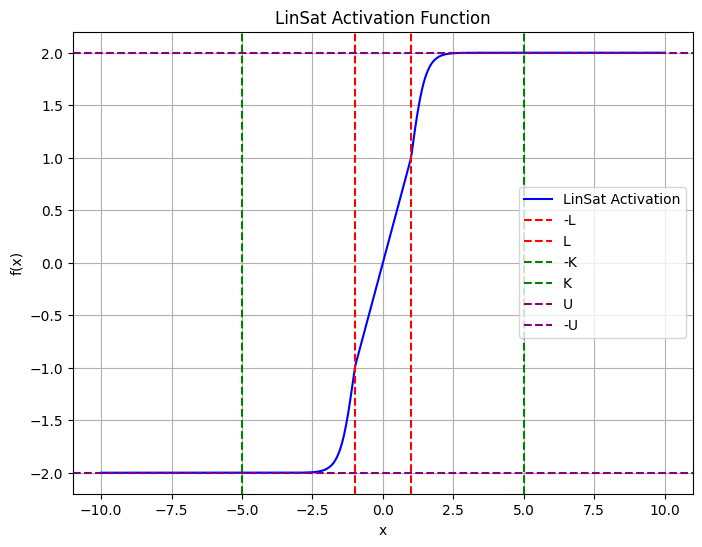

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the LinSat activation parameters
L = 1.0    # Linear region boundary
K = 5.0    # Saturation start boundary
U = 2.0    # Saturation maximum value
gamma = 2.0  # Steepness of transition

@tf.function
def lin_sat(x):
    # Piecewise definition:
    # f(x) = x                              if |x| <= L
    # f(x) = sign(x)*[L + (U - L)*tanh(...)] if L < |x| <= K
    # f(x) = sign(x)*U                     if |x| > K

    abs_x = tf.abs(x)
    sign_x = tf.sign(x)

    # Region masks
    linear_mask = abs_x <= L
    saturation_mask = abs_x > K
    transition_mask = tf.logical_and(abs_x > L, abs_x <= K)

    # Construct piecewise parts
    # 1. Linear region: f(x) = x
    linear_part = x

    # 2. Transition region:
    #    f(x) = sign(x) * [ L + (U - L)*tanh(gamma(|x|-L)) / tanh(gamma(K-L)) ]
    denom = tf.math.tanh(gamma*(K-L))
    scaled_tanh = tf.math.tanh(gamma*(abs_x - L)) / denom
    transition_part = sign_x * (L + (U - L)*scaled_tanh)

    # 3. Saturated region: f(x) = sign(x)*U
    saturation_part = sign_x * U

    # Combine using masks
    f = tf.where(linear_mask, linear_part,
                 tf.where(transition_mask, transition_part, saturation_part))

    return f

# Test the activation function over a range of values
x_values = np.linspace(-10, 10, 500).astype(np.float32)
y_values = lin_sat(x_values)

# Convert to NumPy for plotting
x_np = x_values
y_np = y_values.numpy()

# Visualization
plt.figure(figsize=(8,6))
plt.plot(x_np, y_np, label='LinSat Activation', color='blue')
plt.axvline(-L, color='red', linestyle='--', label='-L')
plt.axvline(L, color='red', linestyle='--', label='L')
plt.axvline(-K, color='green', linestyle='--', label='-K')
plt.axvline(K, color='green', linestyle='--', label='K')
plt.axhline(U, color='purple', linestyle='--', label='U')
plt.axhline(-U, color='purple', linestyle='--', label='-U')

plt.title('LinSat Activation Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
plt.show()


## MNIST ON LinSat

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ReLU Training:
Epoch 1/100, Time: 20.46s, Loss: 0.1687, Val_Loss: 0.0439, Val_Acc: 0.9870
Epoch 2/100, Time: 5.25s, Loss: 0.0629, Val_Loss: 0.0376, Val_Acc: 0.9882
Epoch 3/100, Time: 5.05s, Loss: 0.0500, Val_Loss: 0.0321, Val_Acc: 0.9904
Epoch 4/100, Time: 4.73s, Loss: 0.0394, Val_Loss: 0.0252, Val_Acc: 0.9918
Epoch 5/100, Time: 5.04s, Loss: 0.0361, Val_Loss: 0.0295, Val_Acc: 0.9908
Epoch 6/100, Time: 4.72s, Loss: 0.0315, Val_Loss: 0.0212, Val_Acc: 0.9942
Epoch 7/100, Time: 4.69s, Loss: 0.0283, Val_Loss: 0.0208, Val_Acc: 0.9932
Epoch 8/100, Time: 5.60s, Loss: 0.0245, Val_Loss: 0.0234, Val_Acc: 0.9930
Epoch 9/100, Time: 4.73s, Loss: 0.0235, Val_Loss: 0.0201, Val_Acc: 0.9940
Epoch 10/100, Time: 6.54s, Loss: 0.0202, Val_Loss: 0.0255, Val_Acc: 0.9930
Epoch 11/100, Time: 4.58s, Loss: 0.0198, Val_Loss: 0.0240, Val_Acc: 0.9934
Epoch 12/100, Time: 4.56s, Loss: 0.0185, Val_Loss: 0.0216, Val_Acc: 0.9936
Epoch 13/100, Time: 5.42s, Loss: 0.0133, V

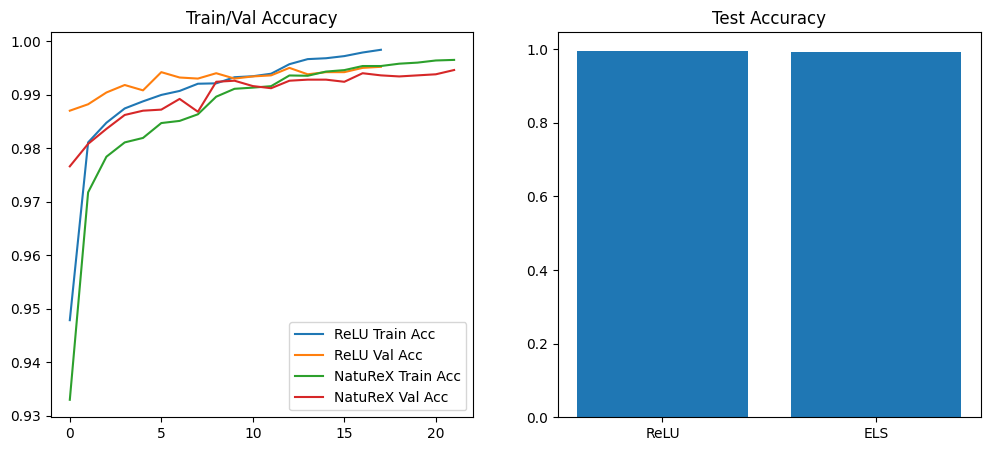

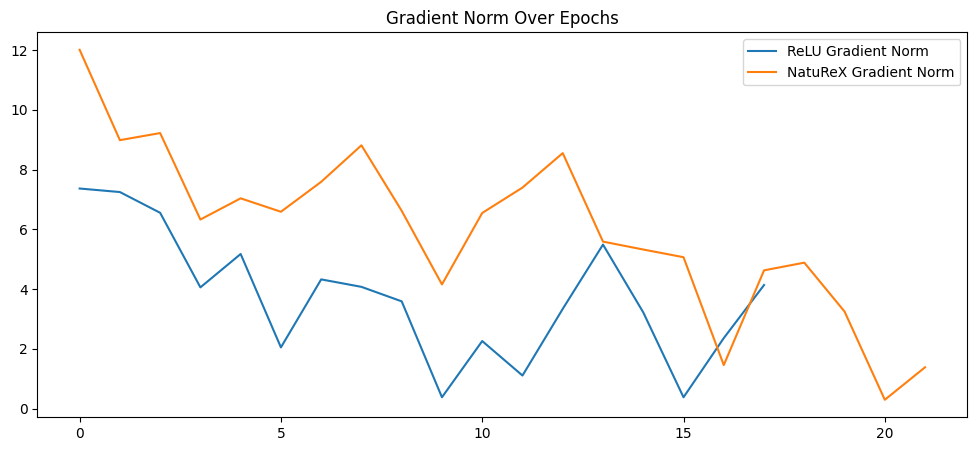

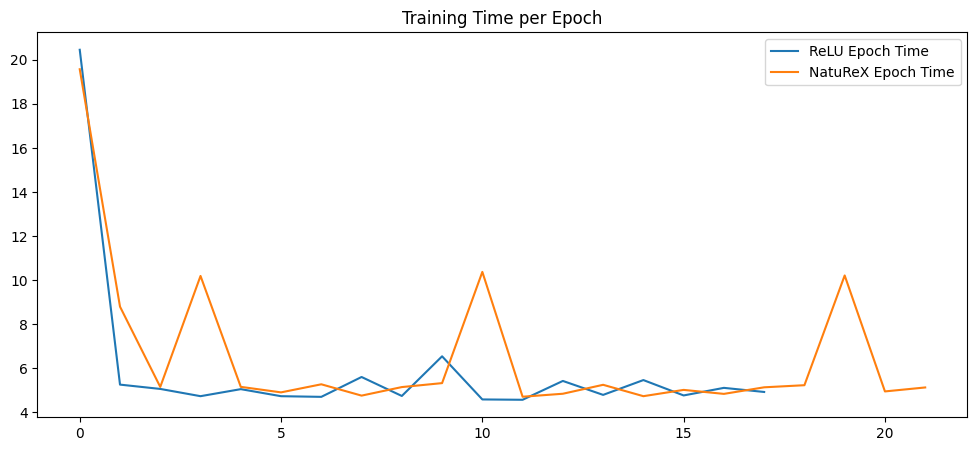

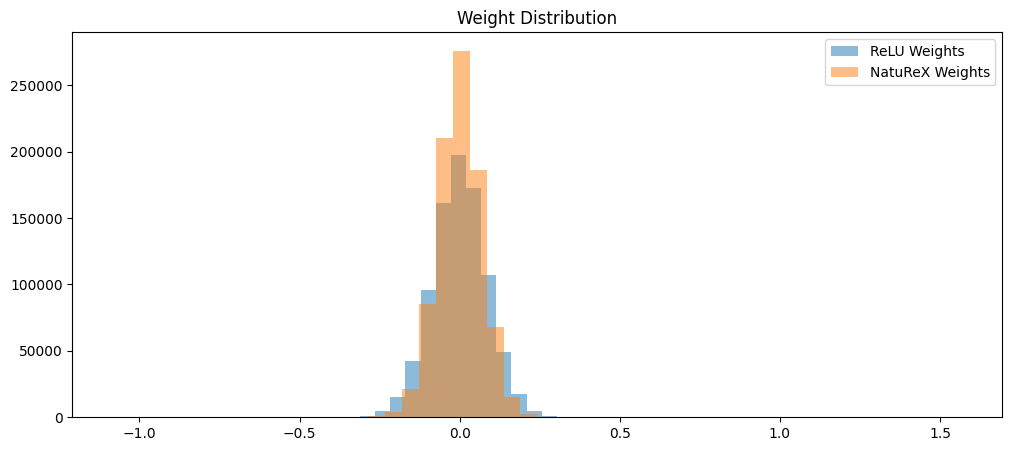

ReLU Model:
Test Accuracy: 0.9959
Sparsity: 0.0002
Total Training Time: 106.40s
NatuReX Model:
Test Accuracy: 0.9926
Sparsity: 0.0002
Total Training Time: 144.55s


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000

# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# Expand dims for CNN (MNIST is grayscale, so 1 channel)
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]


# Define the LinSat activation parameters
L = 1.0    # Linear region boundary
K = 5.0    # Saturation start boundary
U = 2.0    # Saturation maximum value
gamma = 2.0  # Steepness of transition

@tf.function
def els(x):
    # Piecewise definition:
    # f(x) = x                              if |x| <= L
    # f(x) = sign(x)*[L + (U - L)*tanh(...)] if L < |x| <= K
    # f(x) = sign(x)*U                     if |x| > K

    abs_x = tf.abs(x)
    sign_x = tf.sign(x)

    # Region masks
    linear_mask = abs_x <= L
    saturation_mask = abs_x > K
    transition_mask = tf.logical_and(abs_x > L, abs_x <= K)

    # Construct piecewise parts
    # 1. Linear region: f(x) = x
    linear_part = x

    # 2. Transition region:
    #    f(x) = sign(x) * [ L + (U - L)*tanh(gamma(|x|-L)) / tanh(gamma(K-L)) ]
    denom = tf.math.tanh(gamma*(K-L))
    scaled_tanh = tf.math.tanh(gamma*(abs_x - L)) / denom
    transition_part = sign_x * (L + (U - L)*scaled_tanh)

    # 3. Saturated region: f(x) = sign(x)*U
    saturation_part = sign_x * U

    # Combine using masks
    f = tf.where(linear_mask, linear_part,
                 tf.where(transition_mask, transition_part, saturation_part))

    return f


# Initializer
initializer = tf.keras.initializers.HeNormal()

# Build model function
def build_model(activation_func):
    inputs = tf.keras.Input(shape=(28,28,1))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

# Compute sparsity
def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Training for ReLU
print("ReLU Training:")
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

# Training for ELS
print("NatuReX Training:")
model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

callback_els = CustomCallback()
callbacks_els = [
    callback_els,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_els_best.keras", save_best_only=True, monitor='val_loss')
]

history_els = model_els.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=callbacks_els)

test_loss_els, test_acc_els = model_els.evaluate(x_test, y_test, verbose=0)
els_sparsity = compute_sparsity(model_els)

model_relu.save("model_relu_final.keras")
model_els.save("model_els_final.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_els.history['accuracy'], label='NatuReX Train Acc')
plt.plot(history_els.history['val_accuracy'], label='NatuReX Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'ELS'], [test_acc_relu, test_acc_els])
plt.title('Test Accuracy')
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_els.gradient_norms, label='NatuReX Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_els.train_times, label='NatuReX Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
els_weights = np.concatenate([w.numpy().flatten() for w in model_els.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(els_weights, bins=50, alpha=0.5, label='NatuReX Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("NatuReX Model:")
print(f"Test Accuracy: {test_acc_els:.4f}")
print(f"Sparsity: {els_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_els.train_times):.2f}s")


ReLU Training:
Epoch 1/100, Time: 15.62s, Loss: 0.1640, Val_Loss: 0.0519, Val_Acc: 0.9846
Epoch 2/100, Time: 12.31s, Loss: 0.0652, Val_Loss: 0.0366, Val_Acc: 0.9878
Epoch 3/100, Time: 5.00s, Loss: 0.0496, Val_Loss: 0.0355, Val_Acc: 0.9888
Epoch 4/100, Time: 5.43s, Loss: 0.0433, Val_Loss: 0.0243, Val_Acc: 0.9930
Epoch 5/100, Time: 4.91s, Loss: 0.0372, Val_Loss: 0.0248, Val_Acc: 0.9922
Epoch 6/100, Time: 4.85s, Loss: 0.0314, Val_Loss: 0.0258, Val_Acc: 0.9920
Epoch 7/100, Time: 4.99s, Loss: 0.0284, Val_Loss: 0.0221, Val_Acc: 0.9936
Epoch 8/100, Time: 4.70s, Loss: 0.0250, Val_Loss: 0.0176, Val_Acc: 0.9936
Epoch 9/100, Time: 4.98s, Loss: 0.0247, Val_Loss: 0.0229, Val_Acc: 0.9936
Epoch 10/100, Time: 4.79s, Loss: 0.0221, Val_Loss: 0.0196, Val_Acc: 0.9938
Epoch 11/100, Time: 5.32s, Loss: 0.0189, Val_Loss: 0.0210, Val_Acc: 0.9942
Epoch 12/100, Time: 4.88s, Loss: 0.0141, Val_Loss: 0.0167, Val_Acc: 0.9948
Epoch 13/100, Time: 5.24s, Loss: 0.0100, Val_Loss: 0.0151, Val_Acc: 0.9952
Epoch 14/100, Tim

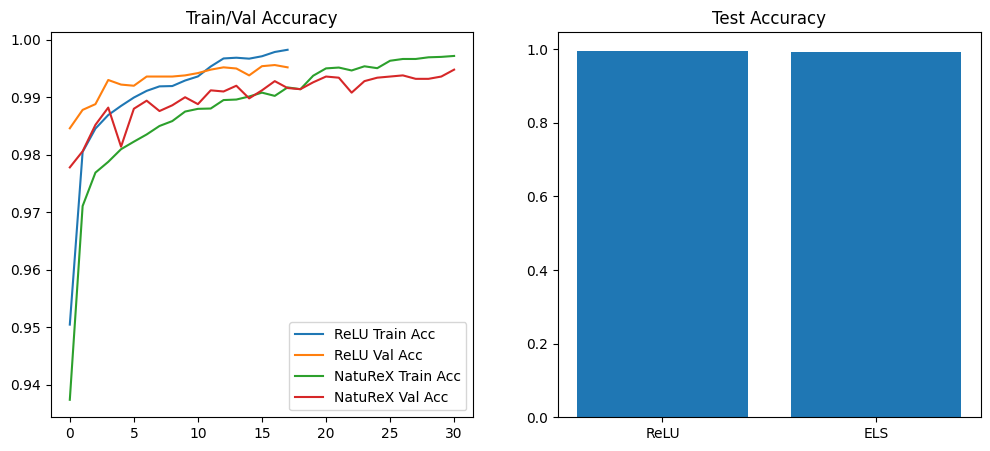

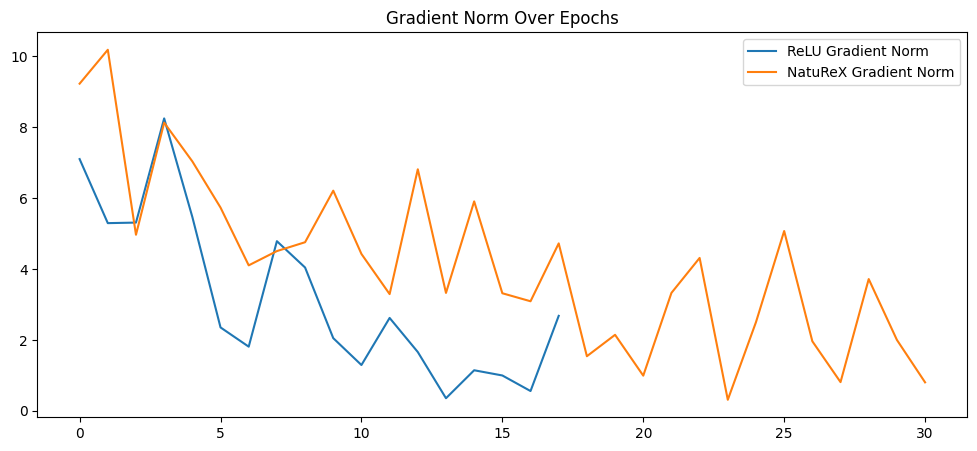

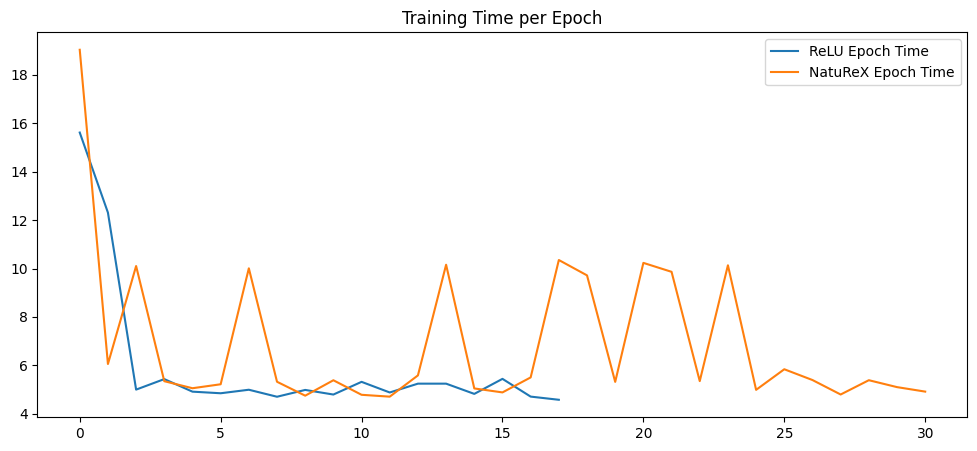

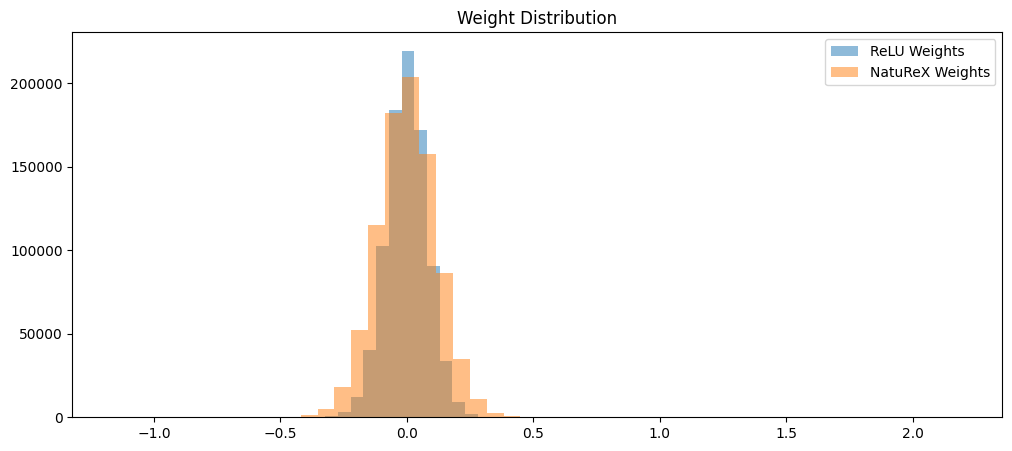

ReLU Model:
Test Accuracy: 0.9957
Sparsity: 0.0002
Total Training Time: 107.82s
NatuReX Model:
Test Accuracy: 0.9920
Sparsity: 0.0001
Total Training Time: 214.31s


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000

# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# Expand dims for CNN (MNIST is grayscale, so 1 channel)
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]


# Define the LinSat activation parameters
L = 2.0    # Linear region boundary
K = 10.0    # Saturation start boundary
U = 3.0    # Saturation maximum value
gamma = 1.0  # Steepness of transition

@tf.function
def els(x):
    # Piecewise definition:
    # f(x) = x                              if |x| <= L
    # f(x) = sign(x)*[L + (U - L)*tanh(...)] if L < |x| <= K
    # f(x) = sign(x)*U                     if |x| > K

    abs_x = tf.abs(x)
    sign_x = tf.sign(x)

    # Region masks
    linear_mask = abs_x <= L
    saturation_mask = abs_x > K
    transition_mask = tf.logical_and(abs_x > L, abs_x <= K)

    # Construct piecewise parts
    # 1. Linear region: f(x) = x
    linear_part = x

    # 2. Transition region:
    #    f(x) = sign(x) * [ L + (U - L)*tanh(gamma(|x|-L)) / tanh(gamma(K-L)) ]
    denom = tf.math.tanh(gamma*(K-L))
    scaled_tanh = tf.math.tanh(gamma*(abs_x - L)) / denom
    transition_part = sign_x * (L + (U - L)*scaled_tanh)

    # 3. Saturated region: f(x) = sign(x)*U
    saturation_part = sign_x * U

    # Combine using masks
    f = tf.where(linear_mask, linear_part,
                 tf.where(transition_mask, transition_part, saturation_part))

    return f


# Initializer
initializer = tf.keras.initializers.HeNormal()

# Build model function
def build_model(activation_func):
    inputs = tf.keras.Input(shape=(28,28,1))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

# Compute sparsity
def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Training for ReLU
print("ReLU Training:")
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

# Training for ELS
print("NatuReX Training:")
model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

callback_els = CustomCallback()
callbacks_els = [
    callback_els,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_els_best.keras", save_best_only=True, monitor='val_loss')
]

history_els = model_els.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=callbacks_els)

test_loss_els, test_acc_els = model_els.evaluate(x_test, y_test, verbose=0)
els_sparsity = compute_sparsity(model_els)

model_relu.save("model_relu_final.keras")
model_els.save("model_els_final.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_els.history['accuracy'], label='NatuReX Train Acc')
plt.plot(history_els.history['val_accuracy'], label='NatuReX Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'ELS'], [test_acc_relu, test_acc_els])
plt.title('Test Accuracy')
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_els.gradient_norms, label='NatuReX Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_els.train_times, label='NatuReX Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
els_weights = np.concatenate([w.numpy().flatten() for w in model_els.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(els_weights, bins=50, alpha=0.5, label='NatuReX Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("NatuReX Model:")
print(f"Test Accuracy: {test_acc_els:.4f}")
print(f"Sparsity: {els_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_els.train_times):.2f}s")



Evaluating ReLU model on FGSM adversaries...
functional_2 accuracy on FGSM (eps=0.1) adversarial examples: 0.6210

Evaluating ELS model on FGSM adversaries...
functional_3 accuracy on FGSM (eps=0.1) adversarial examples: 0.5390

Evaluating ReLU model on PGD adversaries...
functional_2 accuracy on PGD (eps=0.1, alpha=0.01, steps=40) adversarial examples: 0.0720

Evaluating ELS model on PGD adversaries...
functional_3 accuracy on PGD (eps=0.1, alpha=0.01, steps=40) adversarial examples: 0.0010


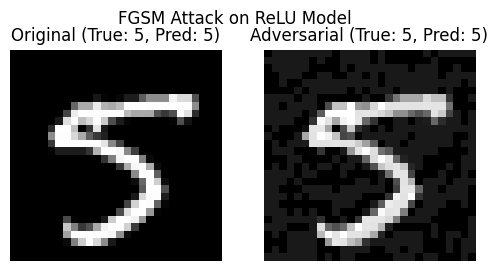

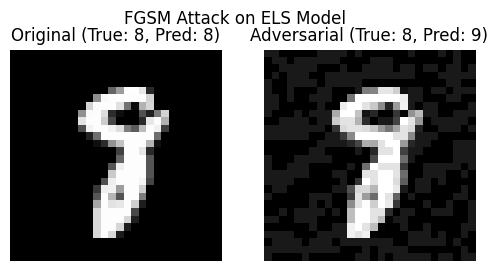

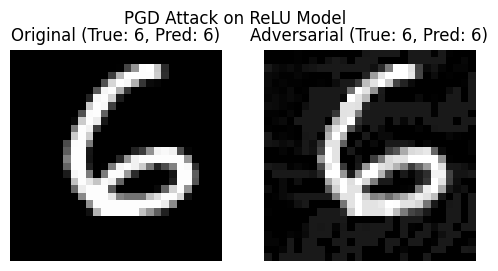

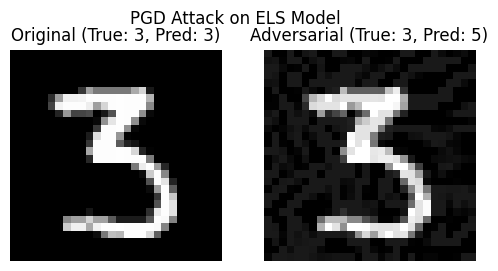

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assume model_relu and model_els are already trained and available
# Assume x_test, y_test are also available (as in the previous code)
# Here we implement FGSM and PGD attacks on a subset of the test data.

# Parameters for attacks
epsilon = 0.1   # For FGSM: Maximum perturbation
pgd_steps = 40   # Number of steps for PGD
pgd_alpha = 0.01 # Step size for PGD
num_samples = 1000  # Number of test samples to evaluate

x_test_subset = x_test[:num_samples]
y_test_subset = y_test[:num_samples]

# Function to perform FGSM attack
def fgsm_attack(model, x, y_true, eps):
    x_adv = tf.identity(x)
    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        preds = model(x_adv, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
    grads = tape.gradient(loss, x_adv)
    # Sign of the gradient
    signed_grads = tf.sign(grads)
    # Add perturbation
    x_adv = x_adv + eps * signed_grads
    # Clip to maintain valid pixel range [0,1]
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

# Function to perform PGD attack
def pgd_attack(model, x, y_true, eps, alpha, steps):
    x_adv = tf.identity(x)
    x_orig = tf.identity(x)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            preds = model(x_adv, training=False)
            loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
        grads = tape.gradient(loss, x_adv)
        signed_grads = tf.sign(grads)
        x_adv = x_adv + alpha * signed_grads
        # Project the perturbation onto the L-infinity ball of radius eps
        x_adv = tf.clip_by_value(x_adv, x_orig - eps, x_orig + eps)
        # Clip to maintain valid pixel range [0,1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

# Evaluate model on adversarial examples
def evaluate_on_adversarial(model, x_data, y_data, attack_fn, attack_name):
    # Generate adversarial examples
    x_adv = attack_fn(model, x_data, y_data)
    # Evaluate accuracy on adversarial examples
    preds = model.predict(x_adv, verbose=0)
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y_data, axis=1))
    print(f"{model.name} accuracy on {attack_name} adversarial examples: {acc:.4f}")
    return x_adv

# Evaluate both models on FGSM adversaries
print("\nEvaluating ReLU model on FGSM adversaries...")
x_adv_relu_fgsm = evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                                          lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                                          f"FGSM (eps={epsilon})")

print("\nEvaluating ELS model on FGSM adversaries...")
x_adv_els_fgsm = evaluate_on_adversarial(model_els, x_test_subset, y_test_subset,
                                         lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                                         f"FGSM (eps={epsilon})")

# Evaluate both models on PGD adversaries
print("\nEvaluating ReLU model on PGD adversaries...")
x_adv_relu_pgd = evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                                         lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                                         f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")

print("\nEvaluating ELS model on PGD adversaries...")
x_adv_els_pgd = evaluate_on_adversarial(model_els, x_test_subset, y_test_subset,
                                        lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                                        f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")

# Visualize some adversarial examples
def visualize_adversarial_examples(x_orig, x_adv, y_true, model, title):
    idx = np.random.randint(0, len(x_orig))
    orig_image = x_orig[idx]
    adv_image = x_adv[idx]
    true_label = np.argmax(y_true[idx])
    pred_orig = np.argmax(model.predict(np.expand_dims(orig_image,0), verbose=0))
    pred_adv = np.argmax(model.predict(np.expand_dims(adv_image,0), verbose=0))

    # Ensure numpy arrays
    if isinstance(orig_image, tf.Tensor):
        orig_image = orig_image.numpy()
    if isinstance(adv_image, tf.Tensor):
        adv_image = adv_image.numpy()

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title(f"Original (True: {true_label}, Pred: {pred_orig})")
    # If shape is (28,28,1), display the first channel
    plt.imshow(orig_image[...,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title(f"Adversarial (True: {true_label}, Pred: {pred_adv})")
    plt.imshow(adv_image[...,0], cmap='gray')
    plt.axis('off')
    plt.suptitle(title)
    plt.show()


# Visualize for FGSM (ReLU)
visualize_adversarial_examples(x_test_subset, x_adv_relu_fgsm, y_test_subset, model_relu, "FGSM Attack on ReLU Model")

# Visualize for FGSM (ELS)
visualize_adversarial_examples(x_test_subset, x_adv_els_fgsm, y_test_subset, model_els, "FGSM Attack on ELS Model")

# Visualize for PGD (ReLU)
visualize_adversarial_examples(x_test_subset, x_adv_relu_pgd, y_test_subset, model_relu, "PGD Attack on ReLU Model")

# Visualize for PGD (ELS)
visualize_adversarial_examples(x_test_subset, x_adv_els_pgd, y_test_subset, model_els, "PGD Attack on ELS Model")
